In [1]:
import cv2
import math
import pywt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:

class DWT(layers.Layer):
    def __init__(self, name='haar'):
        super(DWT, self).__init__()

        # get filter coeffs from 3rd party lib
        wavelet = pywt.Wavelet(name)
        self.dec_len = wavelet.dec_len
        
        # decomposition filter low pass and hight pass coeffs
        db2_lpf = wavelet.dec_lo
        db2_hpf = wavelet.dec_hi

        # covert values into tensor and reshape for convolution math
        db2_lpf = tf.constant(db2_lpf)
        self.db2_lpf = tf.reshape(db2_lpf, (1, wavelet.dec_len, 1, 1))

        db2_hpf = tf.constant(db2_hpf)
        self.db2_hpf = tf.reshape(db2_hpf, (1, wavelet.dec_len, 1, 1))
        
        self.conv_type = "VALID"
        self.border_padd = "SYMMETRIC"

    def build(self, input_shape):
        # filter dims should be bigger if input is not gray scale
        if input_shape[-1] != 1:
            self.db2_lpf = tf.repeat(self.db2_lpf, input_shape[-1], axis=-1)
            self.db2_hpf = tf.repeat(self.db2_hpf, input_shape[-1], axis=-1)

    def call(self, inputs, training=None, mask=None):
        
        # border padding symatric add coulums
        inputs_pad = tf.pad(inputs, [[0, 0], [0, 0], [self.dec_len-1, self.dec_len-1], [0, 0]], self.border_padd)
        
        # approximation conv only rows
        a = tf.nn.conv2d(
            inputs_pad, self.db2_lpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )
        # details conv only rows
        d = tf.nn.conv2d(
            inputs_pad, self.db2_hpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )
        # ds - downsample
        a_ds = a[:, :, 1:a.shape[2]:2, :]
        d_ds = d[:, :, 1:a.shape[2]:2, :]
        
        # border padding symatric add rows
        a_ds_pad = tf.pad(a_ds, [[0, 0], [self.dec_len-1, self.dec_len-1], [0, 0], [0, 0]], self.border_padd)
        d_ds_pad = tf.pad(d_ds, [[0, 0], [self.dec_len-1, self.dec_len-1], [0, 0], [0, 0]], self.border_padd)

        # convolution is done on the rows so we need to
        # transpose the matrix in order to convolve the colums
        a_ds_pad = tf.transpose(a_ds_pad, perm=[0, 2, 1, 3])
        d_ds_pad = tf.transpose(d_ds_pad, perm=[0, 2, 1, 3])

        # aa approximation approximation
        aa = tf.nn.conv2d(
            a_ds_pad, self.db2_lpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )
        # ad approximation details
        ad = tf.nn.conv2d(
            a_ds_pad, self.db2_hpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )
        # ad details aproximation
        da = tf.nn.conv2d(
            d_ds_pad, self.db2_lpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )
        # dd details details
        dd = tf.nn.conv2d(
            d_ds_pad, self.db2_hpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )
        
        # transpose back the matrix 
        aa = tf.transpose(aa, perm=[0, 2, 1, 3])
        ad = tf.transpose(ad, perm=[0, 2, 1, 3])
        da = tf.transpose(da, perm=[0, 2, 1, 3])
        dd = tf.transpose(dd, perm=[0, 2, 1, 3])
        
        # down sample 
        ll = aa[:, 1:aa.shape[1]:2, :, :]
        lh = ad[:, 1:aa.shape[1]:2, :, :]
        hl = da[:, 1:aa.shape[1]:2, :, :]
        hh = dd[:, 1:aa.shape[1]:2, :, :]
        
        # concate all outputs ionto tensor
        x = tf.concat([ll, lh, hl, hh], axis=-1)
        
        return x



In [3]:
name="db3"


In [4]:
img = cv2.imread("../input/LennaGrey.png",0)
img_ex = np.expand_dims(img, axis=-1)
img_ex = np.expand_dims(img_ex, axis=0)

model = keras.Sequential()
model.add(keras.Input(shape=(512, 512, 1)))
model.add(DWT(name=name))
model.summary()

coeffs = model.predict(img_ex)
coeffs.shape

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dwt (DWT)                    (None, 258, 258, 4)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


(1, 258, 258, 4)

(258, 258)


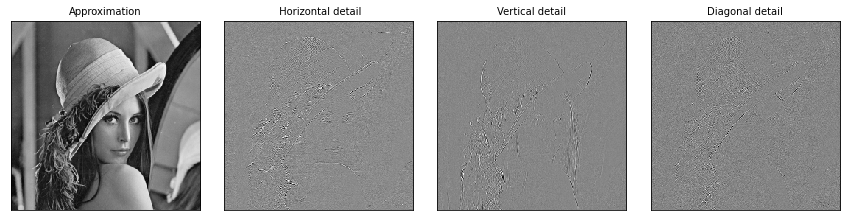

In [5]:
import matplotlib.pyplot as plt
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']

img = cv2.imread("../input/LennaGrey.png",0)
coeffs2 = pywt.dwt2(img, name)
LL, (LH, HL, HH) = coeffs2
print(LL.shape)

fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

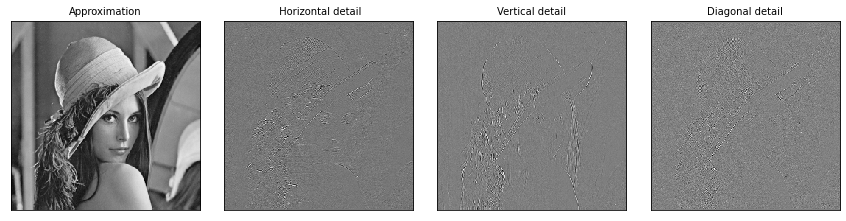

In [6]:

LL = coeffs[0, :, :, 0]
LH = coeffs[0, :, :, 1]
HL = coeffs[0, :, :, 2]
HH = coeffs[0, :, :, 3]
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()